# Profiling tiling of titiler-pgstac and titiler-xarray

This notebook profiles code for tiling CMIP6 data via 2 methods:

1. pgSTAC + COGs: The first method uses a (local or remote) pgSTAC database for storing metadata about COGs on S3. The libraries used are pgstac for reading STAC metadata and rio_tiler's rasterio for reading COGs on S3.
2. kerchunk + netCDF: The second method uses a (local or S3) kerchunk reference file for NetCDF files stored on S3. The libraries used are xarray for reading the Zarr metadata and rio_tiler's XarrayReader for reading data from the NetCDFs on S3.

In the future, the following improvements and additions to this profiling code will be made:

1. Test with a Zarr store. The profiling code will be run on a Zarr store to compare the performance of reading from a Zarr store vs. reading from a NetCDF via kerchunk.
2. Test different chunking strategies: The profiling code will be run on a few different Zarr stores with different chunking schemes.
3. Test a higher resolution dataset.

## Setup / Step 0

1. Load some basic libraries
2. Set an initial tile to test
3. Add some AWS credentials
4. Install any missing libraries

In [1]:
import boto3
import io
from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
xyz_tile = (0,0,0)

In [3]:
#!pip install titiler-pgstac titiler rio_tiler psycopg_pool psycopg loguru geojson_pydantic

## Profile titiler-pgstac

To achieve the best performance, we set some GDAL environment variables.

These variables are documented here https://developmentseed.org/titiler/advanced/performance_tuning/, but that advice is copied into comments below for ease of reference.

In [4]:
# By default GDAL reads the first 16KB of the file, then if that doesn't contain the entire metadata
# it makes one more request for the rest of the metadata.
# In environments where latency is relatively high, AWS S3,
# it may be beneficial to increase this value depending on the data you expect to read.
os.environ['GDAL_INGESTED_BYTES_AT_OPEN'] = '32768'

# It's much better to set EMPTY_DIR because this prevents GDAL from making a LIST request.
# LIST requests are made for sidecar files, which does not apply for COGs
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'EMPTY_DIR'

# Tells GDAL to merge consecutive range GET requests.
os.environ['GDAL_HTTP_MERGE_CONSECUTIVE_RANGES'] = 'YES'

# When set to YES, this attempts to download multiple range requests in parallel, reusing the same TCP connection. 
# Note this is only possible when the server supports HTTP2, which many servers don't yet support.
# There's no downside to setting YES here.
os.environ['GDAL_HTTP_MULTIPLEX'] = 'YES'
os.environ['GDAL_HTTP_VERSION'] = '2'

# Setting this to TRUE enables GDAL to use an internal caching mechanism. It's recommended (strongly).
os.environ['VSI_CACHE'] = 'TRUE'

In [5]:
# useful to always reload the module while its being developed
%load_ext autoreload
%autoreload

# Retrieve credentials for the database
os.environ['STACK_NAME'] = 'eodc-dev-pgSTAC'
sts_client = boto3.client('sts')
response = sts_client.get_caller_identity()
account_id = response['Account']
response = sts_client.assume_role(RoleArn=f'arn:aws:iam::{account_id}:role/eodc-hub-role',
                                  RoleSessionName='tile-benchmarking')
credentials = response['Credentials']
os.environ['AWS_ACCESS_KEY_ID'] = credentials['AccessKeyId']
os.environ['AWS_SECRET_ACCESS_KEY'] = credentials['SecretAccessKey']
os.environ['AWS_SESSION_TOKEN'] = credentials['SessionToken']

# Uncomment this line if using a local database
# os.environ['LOCAL'] == 'True'

import cmip6_pgstac.profile_pgstac as profile_pgstac 

Connected to database


In [6]:
if temporal_resolution == 'daily':
    collection = f"CMIP6_daily_{model}_{variable}"
elif temporal_resolution == 'monthly':
    collection = f"CMIP6_ensemble_monthly_median_{variable}"

query = {
  "collections": [ collection ],
  "filter": {
    "op": "t_intersects",
    "args": [
      {
        "property": "datetime"
      },
      {
        "interval": [
          "1950-04-01T00:00:00Z"           
        ]
      }
    ]
  },
  "filter-lang": "cql2-json"
}

image_and_assets, cprofile = profile_pgstac.tile(*xyz_tile, query=dict(query))
cprofile

{'pgstac-search': 34.43, 'get_tile': [298.53], 'mosaic': 301.04}


{'cprofile': ['   ncalls  tottime  percall  cumtime  percall filename:lineno(function)',
  "       12    0.328    0.027    0.328    0.027 {method 'acquire' of '_thread.lock' objects}",
  "       11    0.039    0.004    0.039    0.004 {method 'poll' of 'select.epoll' objects}",
  '        2    0.001    0.000    0.001    0.000 core.py:3435(__setmask__)',
  '        6    0.001    0.000    0.001    0.000 pq_ctypes.py:292(send_query_params)',
  '        6    0.001    0.000    0.001    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}']}

**NOTES:**

* There are 2 parts to the overall timing of generating the image - `pgstac-search` and `get_tile`.
* `get_tile` above is a list with a timing for each tif. The bulk of this time is in `CustomSTACReader#tile`. That function has a subfunction `_reader` which wraps `src_dst.tile` in `self.reader`.
* The `CustomSTACReader`'s `reader` attribute is `BaseReader` from `rio_tiler.io.base`. There is no init function for BaseReader so I don't think any time is spent initializing the reader.
* `CustomSTACReader` inherits from `MultiBaseReader` so the `#tile` function is defined in that class.
* The `MultiBaseReader#tile` function also has a `_reader` subfunction which is called for each asset.
* The code for rio_tiler's `MultiBaseReader#tile#_reader` can be thought of as a **initialize reader** step and a **tile** step. 
* The bulk of the `get_tile` time is spent in the **initialize reader** step of `MultiBaseReader#tile#_reader`. The initialization of `MultiBaseReader#reader` spends most of it's time in `rasterio.open`. I have not dug into the subcalls of `rasterio.open`
* `MultiBaseReader#tile#tile` is roughly equivalent to `rasterio.io.reader#part` and wraps the reading of the WarpedVRT, so should be the sum of the previous calls.


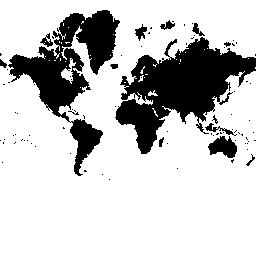

In [7]:
content = image_and_assets[0].render(
    img_format='PNG'
)

im = Image.open(io.BytesIO(content))
im

## Profile titiler-xarray

In [8]:
# useful to always reload the module while its being developed
%load_ext autoreload
%autoreload
import xarray_tile_reader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
image_and_assets, cprofile = xarray_tile_reader.tile(
    f"s3://nasa-eodc-data-store/combined_CMIP6_{temporal_resolution}_{model}_{variable}_kerchunk.json",
    *xyz_tile,
    reference=True,
    anon=False,
    variable=variable,
)
cprofile

Time elapsed for xarray.open_datset: 2871.34
Time elapsed for dimension arrangement and array pre-processing: 14.23
Time elapsed for clipping data via rasterio: 36.1979
Time elapsed for reproject: 131.28948
Time elapsed for creating ImageData: 0.20099


{'cprofile': ['   ncalls  tottime  percall  cumtime  percall filename:lineno(function)',
  "      174    0.907    0.005    0.907    0.005 {method 'acquire' of '_thread.lock' objects}",
  '    17847    0.215    0.000    0.215    0.000 {built-in method builtins.compile}',
  '        1    0.134    0.134    0.134    0.134 message.py:30(Message)',
  '     2674    0.106    0.000    0.738    0.000 typing.py:1773(get_type_hints)',
  '679323/679175    0.095    0.000    0.112    0.000 {built-in method builtins.isinstance}',
  '80022/16044    0.071    0.000    0.339    0.000 typing.py:320(_eval_type)',
  '     7152    0.068    0.000    0.110    0.000 inspect.py:744(cleandoc)',
  '      618    0.065    0.000    0.065    0.000 {built-in method marshal.loads}',
  '    16538    0.052    0.000    0.116    0.000 typing.py:146(_type_check)',
  '  1072/10    0.037    0.000    2.400    0.240 {built-in method builtins.exec}',
  "   258471    0.034    0.000    0.034    0.000 {method 'startswith' of 'str' ob

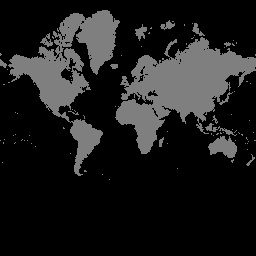

In [10]:
content = image_and_assets.render(
    img_format='PNG'
)

im = Image.open(io.BytesIO(content))
im

In [22]:
image_and_assets, cprofile = xarray_tile_reader.tile(
    f"s3://nasa-eodc-data-store/CMIP6_{temporal_resolution}_{model}_{variable}.zarr",
    *xyz_tile,
    anon=False,
    variable=variable,
)
cprofile

Time elapsed for xarray.open_datset: 541.52
Time elapsed for dimension arrangement and array pre-processing: 10.76
Time elapsed for clipping data via rasterio: 16.9611
Time elapsed for reproject: 3685.22906
Time elapsed for creating ImageData: 0.20599


{'cprofile': ['   ncalls  tottime  percall  cumtime  percall filename:lineno(function)',
  "       34    4.118    0.121    4.118    0.121 {method 'acquire' of '_thread.lock' objects}",
  '        2    0.039    0.020    0.039    0.020 core.py:2223(_decode_chunk)',
  '       29    0.010    0.000    0.051    0.002 core.py:1865(_process_chunk)',
  '        4    0.007    0.002    4.011    1.003 core.py:2009(_chunk_getitems)',
  '        1    0.007    0.007    0.008    0.008 {rasterio._warp._reproject}',
  '      117    0.004    0.000    0.008    0.000 hooks.py:454(_alias_event_name)',
  '       12    0.004    0.000    0.004    0.000 crs.py:985(geodetic_crs)',
  '       15    0.003    0.000    0.003    0.000 crs.py:183(__init__)',
  "     5646    0.002    0.000    0.002    0.000 {method 'index' of 'list' objects}",
  '        2    0.002    0.001    0.002    0.001 {rasterio._warp._transform_bounds}',
  '        4    0.002    0.000    4.014    1.003 core.py:1252(_get_selection)',
  "     7229 